In [263]:
words = open('names.txt', 'r').read().splitlines()

In [264]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [265]:
len(words)

32033

In [266]:
min(len(w) for w in words)

2

In [267]:
max(len(w) for w in words)

15

In [268]:
b = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

In [269]:
sorted(b.items(), key = lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [270]:
import torch

In [271]:
N = torch.zeros((27, 27, 27), dtype=torch.int32)

In [272]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [273]:

for w in words:
  chs = ['.'] + list(w) + ['.']
  # print(chs, chs[1:])
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    N[ix1, ix2, ix3] += 1
    

In [274]:
N[0][1]

tensor([  0, 207, 190,  31, 366,  55,  21,  17,  91, 154,  27,  75, 632, 384,
        623,  10,  17,   9, 482, 194,  72, 152, 243,   6,  27, 173, 152],
       dtype=torch.int32)

In [275]:
p = N[0][1].float()    #tri-gram, so it takes 2 letters or 2 int here.
p = p / p.sum()
p.shape

torch.Size([27])

In [276]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'r'

In [277]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [278]:
P = (N+1).float()
P /= P.sum(2, keepdims=True)

In [279]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix, jx = 0, 0
    while True:
      p = P[ix][jx]
      next_letter = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
      ix = jx
      jx = next_letter
      out.append(itos[next_letter])
      if next_letter == 0:
        break
    print(''.join(out))

quia.
yu.
quinslyntien.
nolliahi.
ha.


In [280]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [281]:
log_likelihood = 0.0
n = 0

for w in words:
#for w in ["andrejq"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    prob = P[ix1, ix2, ix3]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood}')
nll = -log_likelihood
print(f'{nll}')
print(f'{nll/n}')          #orginal was 2.476470470428467, so this is an improvement.

-410414.96875
410414.96875
2.092747449874878


In [282]:
# create the training set of tr-igrams (x,y)
xs, ys = [], []
print("Orginal word: ", words[:1])
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    print(ch1, ch2, ch3)
    xs.append([ix1, ix2])
    ys.append(ix3)

    
xs = torch.tensor(xs)
ys = torch.tensor(ys)


Orginal word:  ['emma']
. e m
e m m
m m a
m a .


In [283]:
xs

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1]])

In [284]:
ys

tensor([13, 13,  1,  0])

In [285]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,

In [286]:
xenc.shape

torch.Size([4, 2, 27])

In [287]:
# plt.imshow(xenc)

In [288]:
xenc.dtype, xenc.shape

(torch.float32, torch.Size([4, 2, 27]))

In [289]:
W = torch.randn((27*2, 1))
out1 = xenc.view(4, -1) @ W
out1.shape

torch.Size([4, 1])

In [290]:
logits = xenc.view(4, -1) @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[1.],
        [1.],
        [1.],
        [1.]])

In [291]:
probs[0]

tensor([1.])

In [292]:
probs[0].shape

torch.Size([1])

In [293]:
probs[0].sum()

tensor(1.)

In [294]:
# (5, 27) @ (27, 27) -> (5, 27)

In [295]:
# SUMMARY ------------------------------>>>>

In [296]:
xs

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1]])

In [297]:
ys

tensor([13, 13,  1,  0])

In [298]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g)

In [299]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc.view(-1, 27*2) @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [300]:
probs.shape

torch.Size([4, 27])

In [301]:

nlls = torch.zeros(4)
for i in range(4):
  # i-th trigram:
  x1 = xs[i][0].item() # input character index
  x2 = xs[i][1].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'trigram example {i+1}: {itos[x1]} {itos[x2]} {itos[y]} (indexes {x1},{x2},{y})')
  print('input to the neural net:', x1, x2)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
trigram example 1: . e m (indexes 0,5,13)
input to the neural net: 0 5
output probabilities from the neural net: tensor([0.0237, 0.0177, 0.0107, 0.0049, 0.0223, 0.0096, 0.0111, 0.0090, 0.0071,
        0.0424, 0.0704, 0.0511, 0.0196, 0.0240, 0.2683, 0.0824, 0.0320, 0.0058,
        0.1061, 0.0203, 0.0267, 0.0060, 0.0026, 0.0565, 0.0026, 0.0264, 0.0407])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.023988453671336174
log likelihood: -3.730182647705078
negative log likelihood: 3.730182647705078
--------
trigram example 2: e m m (indexes 5,13,13)
input to the neural net: 5 13
output probabilities from the neural net: tensor([0.0224, 0.0482, 0.0110, 0.0675, 0.0691, 0.0033, 0.0108, 0.0058, 0.0093,
        0.0043, 0.1095, 0.0867, 0.0058, 0.0074, 0.0009, 0.0084, 0.0135, 0.0044,
        0.0651, 0.0046, 0.0327, 0.0632, 0.0720, 0.0006, 0.0040, 0.0079, 0.2616])
label (actual next character): 13
probability assigned by the net to the the 

In [302]:
# --------- !!! OPTIMIZATION !!! yay --------------

In [303]:
xs

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1]])

In [304]:
ys

tensor([13, 13,  1,  0])

In [305]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

In [306]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc.view(4, 2*27) @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(4), ys].log().mean()

In [92]:
print(loss.item())

4.095324993133545


In [93]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [94]:
W.data += -0.1 * W.grad

In [95]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [96]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    xs.append([ix1, ix2])
    ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()


# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

In [97]:
# gradient descent
for k in range(100):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc.view(-1, 27*2) @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(ys.shape[0]), ys].log().mean() + 0.01*(W**2).mean()    #divided by 2 because we have a bigram here
  if(k>95):
    print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

2.2735965251922607
2.273299217224121
2.2730088233947754
2.272723436355591


Exercises 1:
E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

As we can see, the orginal one has final loss of 2.46, and this one has 2.27. We do have improvement.

In [98]:
t1 = F.one_hot(xs, num_classes=27).float()
t1[0]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [99]:
import random

In [100]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  iy = random.randint(1, 26)
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix, iy]), num_classes=27).float()
    logits = xenc.view(-1, 27*2) @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

rtn.
ayo.
rnonvnsrynbs.
ejeiiaelaea.
uuuutuzcuunaudlunujuehqbuqamkouuuouumulorxvpx.


Exercises 2:
E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

Part1: bigram:

In [101]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [102]:
total = len(xs)
train_end, dev_end = int(total*0.8), int(total*0.9)
Xtr, Ytr= xs[:train_end],  ys[:train_end]
Xdev, Ydev= xs[train_end:dev_end],  ys[train_end:dev_end]
Xtest, Ytest= xs[dev_end:],  ys[dev_end:]

In [103]:
# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W_bgram = torch.randn((27, 27), generator=g, requires_grad=True)

In [104]:
F.one_hot(Xtr, num_classes=27).float().shape, Ydev.shape, Ytest.shape

(torch.Size([182516, 27]), torch.Size([22815]), torch.Size([22815]))

In [105]:
last10_train_loss = []
last10_dev_loss = []
# gradient descent
for k in range(100):
  # forward pass
  xenc = F.one_hot(Xtr, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W_bgram  # doing the prediction
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  
  loss_tr = -probs[torch.arange(Ytr.shape[0]), Ytr].log().mean() + 0.01 * (W_bgram**2).mean() 
  if(k>=90):

    #the dev loss part
    with torch.no_grad():
      xdenc = F.one_hot(Xdev, num_classes=27).float() # input to the network: one-hot encoding

      logits_dev = xdenc @ W_bgram  # doing the prediction
      counts_dev = logits_dev.exp()
      probs_dev = counts_dev / counts_dev.sum(1, keepdims=True)

      # I am not going to put the L2 regularization on dev set
      loss_dev = -probs_dev[torch.arange(Ydev.shape[0]), Ydev].log().mean()
      
    print(f'Training loss: {loss_tr} and the dev set loss: {loss_dev}')
    last10_train_loss.append(loss_tr.item())
    last10_dev_loss.append(loss_dev.item())
  # backward pass
  W_bgram.grad = None # set to zero the gradient
  # print(loss)
  loss_tr.backward()

  # update
  W_bgram.data +=-50 * W_bgram.grad
print("Mean of the last 10 training loss: ", sum(last10_train_loss)/10)
print("Mean of the last 10 dev set loss: ", sum(last10_dev_loss)/10)

Training loss: 2.46297550201416 and the dev set loss: 2.615262031555176
Training loss: 2.462754726409912 and the dev set loss: 2.614959478378296
Training loss: 2.4625394344329834 and the dev set loss: 2.6146652698516846
Training loss: 2.462329864501953 and the dev set loss: 2.6143789291381836
Training loss: 2.4621260166168213 and the dev set loss: 2.61409854888916
Training loss: 2.4619271755218506 and the dev set loss: 2.6138250827789307
Training loss: 2.461733341217041 and the dev set loss: 2.613558530807495
Training loss: 2.4615445137023926 and the dev set loss: 2.613295316696167
Training loss: 2.461360216140747 and the dev set loss: 2.6130406856536865
Training loss: 2.4611804485321045 and the dev set loss: 2.612790107727051
Mean of the last 10 training loss:  2.4620471239089965
Mean of the last 10 dev set loss:  2.613987398147583


This is a good result for bi-gram model. 2.4 and 2.61 are very close to each others, so this may be the case of underfitting. But the 0.2 it not really small, so I think it is not really a underfitting.

In [106]:
with torch.no_grad():
  test_loss = []
  # gradient descent
  for k in range(10):
    # forward pass
    xenc = F.one_hot(Xtest, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc @ W_bgram  # doing the prediction
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)

    loss = -probs[torch.arange(Ytest.shape[0]), Ytest].log().mean()
    test_loss.append(loss.item())

  print("Mean of the 10 test loss: ", sum(test_loss)/10)

Mean of the 10 test loss:  2.6166775226593018


The dev and test splits are very close to each other.

Part 2 trigram:

In [312]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    xs.append([ix1, ix2])
    ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [313]:
total = len(xs)
train_end, dev_end = int(total*0.8), int(total*0.9)
Xtr, Ytr= xs[:train_end],  ys[:train_end]
Xdev, Ydev= xs[train_end:dev_end],  ys[train_end:dev_end]
Xtest, Ytest= xs[dev_end:],  ys[dev_end:]

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W_trigram = torch.randn((27*2, 27), generator=g, requires_grad=True)

In [109]:
last10_train_loss = []
last10_dev_loss = []
# gradient descent
for k in range(100):
  # forward pass
  xenc = F.one_hot(Xtr, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc.view(-1, 27*2) @ W_trigram  # doing the prediction
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  
  loss_tr = -probs[torch.arange(Ytr.shape[0]), Ytr].log().mean() + 0.01 * (W_trigram**2).mean() 
  if(k>=90):

    #the dev loss part
    with torch.no_grad():
      xdenc = F.one_hot(Xdev, num_classes=27).float() # input to the network: one-hot encoding

      logits_dev = xdenc.view(-1, 27*2) @ W_trigram  # doing the prediction
      counts_dev = logits_dev.exp()
      probs_dev = counts_dev / counts_dev.sum(1, keepdims=True)

      # I am not going to put the L2 regularization on dev set
      loss_dev = -probs_dev[torch.arange(Ydev.shape[0]), Ydev].log().mean()
      
    print(f'Training loss: {loss_tr} and the dev set loss: {loss_dev}')
    last10_train_loss.append(loss_tr.item())
    last10_dev_loss.append(loss_dev.item())
  # backward pass
  W_trigram.grad = None # set to zero the gradient
  # print(loss)
  loss_tr.backward()

  # update
  W_trigram.data +=-50 * W_trigram.grad
print("Mean of the last 10 training loss: ", sum(last10_train_loss)/10)
print("Mean of the last 10 dev set loss: ", sum(last10_dev_loss)/10)

Training loss: 2.23776912689209 and the dev set loss: 2.4524118900299072
Training loss: 2.2374212741851807 and the dev set loss: 2.4520208835601807
Training loss: 2.237081527709961 and the dev set loss: 2.451639175415039
Training loss: 2.2367494106292725 and the dev set loss: 2.451265335083008
Training loss: 2.236424446105957 and the dev set loss: 2.4509003162384033
Training loss: 2.236107110977173 and the dev set loss: 2.4505436420440674
Training loss: 2.2357964515686035 and the dev set loss: 2.4501943588256836
Training loss: 2.235492467880249 and the dev set loss: 2.44985294342041
Training loss: 2.235194444656372 and the dev set loss: 2.449518918991089
Training loss: 2.234903573989868 and the dev set loss: 2.4491918087005615
Mean of the last 10 training loss:  2.236293983459473
Mean of the last 10 dev set loss:  2.450753927230835


In [110]:
with torch.no_grad():
  # gradient descent

  # forward pass
  xenc = F.one_hot(Xtest, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc.view(-1, 27*2) @ W_trigram  # doing the prediction
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)

  loss = -probs[torch.arange(Ytest.shape[0]), Ytest].log().mean()
  print("Test loss: ", loss.item())

Test loss:  2.4469966888427734


We can see we have a similar behavior on tri-gram and bi-gram, which the training loss has different of 0.2.
We can see the tri-gram is better than the bi-gram.

Exercises 3:
Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [111]:
import matplotlib.pyplot as plt

In [112]:

regs=[1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]


for r in regs:
    # # initialize the 'network'
    g = torch.Generator().manual_seed(2147483647)
    W_trigram = torch.randn((27*2, 27), generator=g, requires_grad=True)
    print(f"---------with smooting value of {r}-------------")
    train_loss = []
    dev_loss = []
    # gradient descent
    for k in range(100):
        # forward pass
        xenc = F.one_hot(Xtr, num_classes=27).float() # input to the network: one-hot encoding
        logits = xenc.view(-1, 27*2) @ W_trigram  # doing the prediction
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        
        loss_tr = -probs[torch.arange(Ytr.shape[0]), Ytr].log().mean() + r * (W_trigram**2).mean() 


        #the dev loss part
        with torch.no_grad():
            xdenc = F.one_hot(Xdev, num_classes=27).float() # input to the network: one-hot encoding

            logits_dev = xdenc.view(-1, 27*2) @ W_trigram  # doing the prediction
            counts_dev = logits_dev.exp()
            probs_dev = counts_dev / counts_dev.sum(1, keepdims=True)

            # I am not going to put the L2 regularization on dev set
            loss_dev = -probs_dev[torch.arange(Ydev.shape[0]), Ydev].log().mean()
            
        train_loss.append(loss_tr.item())
        dev_loss.append(loss_dev.item())

        # backward pass
        W_trigram.grad = None # set to zero the gradient
        loss_tr.backward()

        # update
        W_trigram.data +=-50 * W_trigram.grad
    print("Mean of training loss: ", sum(train_loss)/len(train_loss))
    print("Mean of dev set loss: ", sum(dev_loss)/len(dev_loss))
    print("----------------------------")

---------with smooting value of 1-------------
Mean of training loss:  2.6055288100242615
Mean of dev set loss:  2.5872700142860414
----------------------------
---------with smooting value of 0.5-------------
Mean of training loss:  2.5151593542099
Mean of dev set loss:  2.557986719608307
----------------------------
---------with smooting value of 0.1-------------
Mean of training loss:  2.3942275857925415
Mean of dev set loss:  2.5475563406944275
----------------------------
---------with smooting value of 0.05-------------
Mean of training loss:  2.368103895187378
Mean of dev set loss:  2.5511179327964784
----------------------------
---------with smooting value of 0.01-------------
Mean of training loss:  2.3415348315238953
Mean of dev set loss:  2.5562044095993044
----------------------------
---------with smooting value of 0.005-------------
Mean of training loss:  2.3377080392837524
Mean of dev set loss:  2.5570207262039184
----------------------------
---------with smooting va

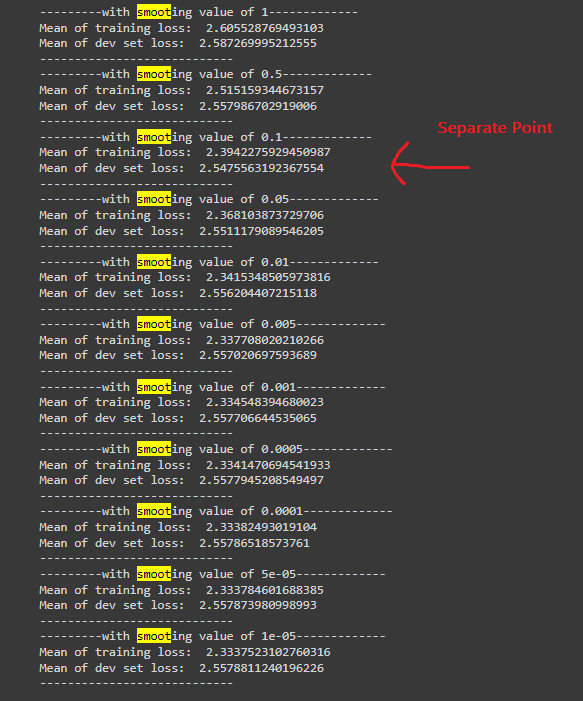

Result: We can see just like the lecture. If the smoothing value is too high, the possibility will be uniform, so the loss will increase. In addition, if the smoothing value is too low, the loss increase since the weight will be too low.




Exercises 4:
E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [115]:
Xtr[0]

tensor([0, 5])

In [324]:
xenc = F.one_hot(xs, num_classes=27).float()
xenc_pre = torch.zeros(*xs.shape, 27)

In [309]:

# xenc_pre
probs.shape, ys.shape

(torch.Size([4, 27]), torch.Size([4]))

In [317]:
xenc_pre[:,0,:].shape, xs[:,0].shape, xenc_pre.shape, xs.shape,

(torch.Size([196113, 27]),
 torch.Size([196113]),
 torch.Size([196113, 2, 27]),
 torch.Size([196113, 2]))

In [328]:
xenc_pre[torch.arange(196113), 0, xs[:,0]] = 1
xenc_pre

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        [[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.]]])

In [329]:
xenc_pre[torch.arange(196113), 1, xs[:,1]] = 1

In [332]:
xenc_pre[5]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [333]:
torch.allclose(xenc_pre, xenc)

True

Exercise 5
E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

That is because the exp function will result in very large number that the computer can not handle, such that it will print out inf.





As a result, we just add the row together to stack them up.

Exercise 6
E06: meta-exercise! Think of a fun/interesting exercise and complete it.
Try to decrease the learning rate at the end.

In [ ]:
# # initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W_trigram = torch.randn((27, 27), generator=g, requires_grad=True)
print(f"---------with smooting value of {r}-------------")
train_loss = []
dev_loss = []
# gradient descent
lr = 50
for k in range(100):
    # forward pass
    xenc = (F.one_hot(Xtr, num_classes=27)[:,0]+ F.one_hot(Xtr, num_classes=27)[:,1]).float() # input to the network: one-hot encoding
    logits = xenc @ W_trigram  # doing the prediction
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    
    loss_tr = -probs[torch.arange(Ytr.shape[0]), Ytr].log().mean() + 0.1 * (W_trigram**2).mean() 


    #the dev loss part
    with torch.no_grad():
        xdenc = (F.one_hot(Xdev, num_classes=27)[:,0]+ F.one_hot(Xdev, num_classes=27)[:,1]).float()# input to the network: one-hot encoding

        logits_dev = xdenc @ W_trigram  # doing the prediction
        counts_dev = logits_dev.exp()
        probs_dev = counts_dev / counts_dev.sum(1, keepdims=True)

        # I am not going to put the L2 regularization on dev set
        loss_dev = -probs_dev[torch.arange(Ydev.shape[0]), Ydev].log().mean()
        
    train_loss.append(loss_tr.item())
    dev_loss.append(loss_dev.item())

    # backward pass
    W_trigram.grad = None # set to zero the gradient
    loss_tr.backward()

    # update
    if(k==75):
        lr = 25
    W_trigram.data +=-lr * W_trigram.grad
print("Mean of training loss: ", sum(train_loss)/len(train_loss))
print("Mean of dev set loss: ", sum(dev_loss)/len(dev_loss))

---------with smooting value of 1e-05-------------
Mean of training loss:  2.631999144554138
Mean of dev set loss:  2.723759572505951


In [ ]:
with torch.no_grad():
  # gradient descent

  # forward pass
  xenc =(F.one_hot(Xtest, num_classes=27)[:,0]+ F.one_hot(Xtest, num_classes=27)[:,1]).float() # input to the network: one-hot encoding
  logits = xenc@ W_trigram  # doing the prediction
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)

  loss = -probs[torch.arange(Ytest.shape[0]), Ytest].log().mean()
  print("Test loss: ", loss.item())

Test loss:  2.558659791946411
